<a href="https://colab.research.google.com/github/RPGraciotti/BootCampAlura/blob/main/Modulo_5/Aula_5_Desafios_em_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Preparando o conteúdo anterior:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold

dados = pd.read_excel("https://github.com/alura-cursos/covid-19-clinical/blob/main/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true")
### também posso usar o link no meu repositório

def preenche_tabela(dados):
    features_continuas_colunas = dados.iloc[:, 13:-2].columns
    features_continuas = dados.groupby("PATIENT_VISIT_IDENTIFIER", as_index=False)[features_continuas_colunas].fillna(method='bfill').fillna(method='ffill')
    features_categoricas = dados.iloc[:, :13]
    saida = dados.iloc[:, -2:]
    dados_finais = pd.concat([features_categoricas, features_continuas, saida], ignore_index=True,axis=1)
    dados_finais.columns = dados.columns
    return dados_finais

dados_limpos = preenche_tabela(dados)
a_remover = dados_limpos.query("WINDOW=='0-2' and ICU==1")['PATIENT_VISIT_IDENTIFIER'].values
dados_limpos = dados_limpos.query("PATIENT_VISIT_IDENTIFIER not in @a_remover")
dados_limpos = dados_limpos.dropna()

def prepare_window(rows):
    if(np.any(rows["ICU"])):
        rows.loc[rows["WINDOW"]=="0-2", "ICU"] = 1
    return rows.loc[rows["WINDOW"] == "0-2"]

dados_limpos = dados_limpos.groupby("PATIENT_VISIT_IDENTIFIER").apply(prepare_window)
dados_limpos.AGE_PERCENTIL = dados_limpos.AGE_PERCENTIL.astype("category").cat.codes # transformando em variaveis categoricas

modelo = LogisticRegression(max_iter=10000)
modelo_arvore = DecisionTreeClassifier()



In [2]:
def roda_modelo_cv(modelo, dados, n_splits, n_repeats):

    np.random.seed(1231234) # lembrando sempre que é para valor didático
    dados = dados.sample(frac = 1).reset_index(drop = True) # embaralha
    x_columns = dados.columns
    y = dados["ICU"]
    x = dados[x_columns].drop(["ICU","WINDOW"], axis=1)

    cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats = n_repeats)
    resultados = cross_validate(modelo, x, y, cv = cv, scoring = "roc_auc")

    auc_medio = np.mean(resultados["test_score"])
    auc_std = np.std(resultados["test_score"])

    print(f"AUC Médio {auc_medio}") 
    print(f"Intervalo {auc_medio - (2 * auc_std)} - {auc_medio + (2 * auc_std)}")


In [3]:
roda_modelo_cv(modelo, dados_limpos, 5, 10)

AUC Médio 0.757641695223932
Intervalo 0.6355431542339184 - 0.8797402362139456


# Aula 5

In [4]:
roda_modelo_cv(modelo_arvore, dados_limpos, n_splits = 5, n_repeats = 10)

AUC Médio 0.6279279683391525
Intervalo 0.4988394445682657 - 0.7570164921100394


In [5]:
modelo_arvore = DecisionTreeClassifier(max_depth = 10)

roda_modelo_cv(modelo_arvore, dados_limpos, n_splits = 5, n_repeats = 10)

AUC Médio 0.5917582923832925
Intervalo 0.4430725313263285 - 0.7404440534402564


In [6]:
def roda_modelo_cv(modelo, dados, n_splits, n_repeats):

    np.random.seed(1231234) # lembrando sempre que é para valor didático
    dados = dados.sample(frac = 1).reset_index(drop = True) # embaralha
    x_columns = dados.columns
    y = dados["ICU"]
    x = dados[x_columns].drop(["ICU","WINDOW"], axis=1)

    cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats = n_repeats)
    resultados = cross_validate(modelo, x, y, cv = cv, scoring = "roc_auc", return_train_score = True)

    auc_medio = np.mean(resultados["test_score"])
    auc_medio_treino = np.mean(resultados["train_score"])
    auc_std = np.std(resultados["test_score"])

    print(f"AUC {auc_medio} - {auc_medio_treino}") 
    return auc_medio, auc_medio_treino

   # print(f"AUC Médio {auc_medio}") 
   # print(f"Intervalo {auc_medio - (2 * auc_std)} - {auc_medio + (2 * auc_std)}")


In [7]:
teste_lista = []
treino_lista = []

for i in range(1,20):
  modelo_arvore = DecisionTreeClassifier(max_depth = i)
  teste, treino = roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)
  teste_lista.append(teste)
  treino_lista.append(treino)

AUC 0.5755830262080263 - 0.6445982993536308
AUC 0.6544700741411268 - 0.75415524801741
AUC 0.6643847795163584 - 0.8243714304989842
AUC 0.6554932930837536 - 0.8832038893699776
AUC 0.6475058192163456 - 0.9275331115338461
AUC 0.6239047951959137 - 0.9567921210944048
AUC 0.6117738776455882 - 0.9745102329260463
AUC 0.5987671815056683 - 0.9855938255169409
AUC 0.5877544694814432 - 0.991376822665679
AUC 0.5917582923832925 - 0.9946888385564852
AUC 0.6009579413444545 - 0.9970452758822465
AUC 0.6147261533363507 - 0.9986297665919551
AUC 0.6212348996723998 - 0.9994661199548005
AUC 0.6256292095025647 - 0.9998695491440995
AUC 0.6279608630759947 - 0.9999883726808554
AUC 0.6279279683391525 - 1.0
AUC 0.6279279683391525 - 1.0
AUC 0.6279279683391525 - 1.0
AUC 0.6279279683391525 - 1.0


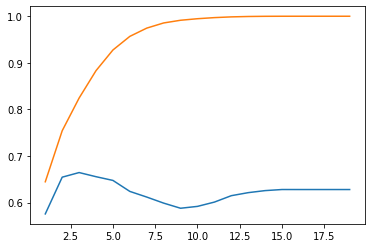

In [8]:
x = range(1, 20)
plt.plot(x, teste_lista)
plt.plot(x, treino_lista)

# exemplo, escolher max_depth de 3

In [9]:
from sklearn.ensemble import RandomForestClassifier

In [10]:
teste_lista = []
treino_lista = []

# mudar n_estimators ao inves de max_depth

for i in range(1,15):
  modelo_arvore = RandomForestClassifier(max_depth = i)
  teste, treino = roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)
  teste_lista.append(teste)
  treino_lista.append(treino)

AUC 0.7754785968683994 - 0.8549995635150238
AUC 0.7868632672744513 - 0.8976687127896622
AUC 0.7931550390103022 - 0.9403124842531797
AUC 0.7983565832578993 - 0.9709123570096604
AUC 0.7990938591103065 - 0.98788117359786
AUC 0.8004527808310704 - 0.9959760554693325
AUC 0.7994808369972844 - 0.9990287365273224
AUC 0.7977776116427432 - 0.9998630161707951
AUC 0.7963008103797579 - 0.9999847540078024
AUC 0.7927381904931247 - 1.0
AUC 0.7928442699577567 - 1.0
AUC 0.7923345025647657 - 1.0
AUC 0.7939161507500323 - 1.0
AUC 0.7939437314108367 - 1.0


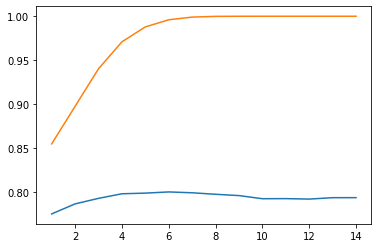

In [11]:
x = range(1, 15)
plt.plot(x, teste_lista)
plt.plot(x, treino_lista)


In [12]:
modelo_arvore = RandomForestClassifier(n_estimators = 10)
teste, treino = roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)

AUC 0.7428159147484805 - 0.999444041300827


In [13]:
modelo_arvore = RandomForestClassifier(n_estimators = 100)
teste, treino = roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)


AUC 0.7939557739557739 - 1.0


In [14]:
modelo_arvore = RandomForestClassifier(n_estimators = 200)
teste, treino = roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)


AUC 0.7950421219664641 - 1.0


# Desafio 01 - Deixar o gráfico de AUC "bonitão" (Silveira, Guilherme)

In [15]:
teste_lista_arvore = []
treino_lista_arvore = []

for i in range(1,21):
  modelo_arvore = DecisionTreeClassifier(max_depth = i)
  teste, treino = roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)
  teste_lista_arvore.append(teste)
  treino_lista_arvore.append(treino)

AUC 0.5755830262080263 - 0.6445982993536308
AUC 0.6544700741411268 - 0.75415524801741
AUC 0.6643847795163584 - 0.8243714304989842
AUC 0.6554932930837536 - 0.8832038893699776
AUC 0.6475058192163456 - 0.9275331115338461
AUC 0.6239047951959137 - 0.9567921210944048
AUC 0.6117738776455882 - 0.9745102329260463
AUC 0.5987671815056683 - 0.9855938255169409
AUC 0.5877544694814432 - 0.991376822665679
AUC 0.5917582923832925 - 0.9946888385564852
AUC 0.6009579413444545 - 0.9970452758822465
AUC 0.6147261533363507 - 0.9986297665919551
AUC 0.6212348996723998 - 0.9994661199548005
AUC 0.6256292095025647 - 0.9998695491440995
AUC 0.6279608630759947 - 0.9999883726808554
AUC 0.6279279683391525 - 1.0
AUC 0.6279279683391525 - 1.0
AUC 0.6279279683391525 - 1.0
AUC 0.6279279683391525 - 1.0
AUC 0.6279279683391525 - 1.0


In [16]:
lista_arvore = pd.DataFrame({
    "teste": teste_lista_arvore,
    "treino": treino_lista_arvore,
    "x": list(range(1, 21))})

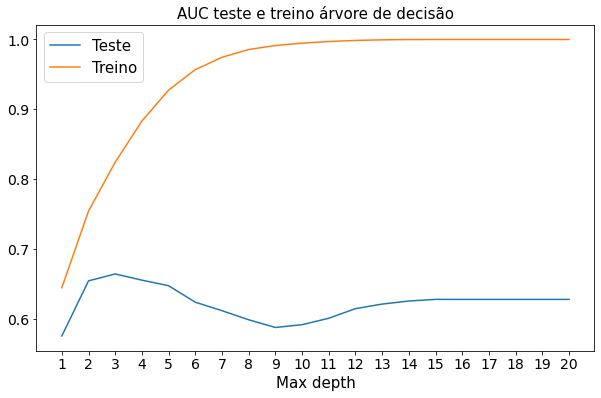

In [17]:
plt.figure(figsize = (10, 6))
ax = plt.gca()
plt.title("AUC teste e treino árvore de decisão", fontsize = 15)
lista_arvore.plot(kind='line', x="x", y='teste',ax=ax)
lista_arvore.plot(kind='line', x="x", y='treino', ax=ax)
plt.legend(fontsize = 15, labels = ["Teste", "Treino"])
plt.xlabel("Max depth", fontsize = 15)
plt.xticks(list(range(1,21)))
plt.tick_params(axis = "both", which = "major", labelsize = 14)
plt.show()
# exemplo, escolher max_depth de 3

# Desafio 02 - Criar um sobreajuste com outra base de dados, outro modelo de ML e plotar o gráfico para análise (dica:base do titanic)

In [18]:
# Vou fazer bem simples, sem entrar em muitos detalhes do que é necessário corrigr do dataset do titanic, só
# para poder estudar o proposto no desafio

tc = pd.read_csv("https://raw.githubusercontent.com/RPGraciotti/BootCampAlura/main/Data/train.csv")
tc

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [19]:
tc_data = tc.loc[:,["Survived", "Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]]
tc_data = tc_data.dropna()
tc_data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
885,0,3,female,39.0,0,5,29.1250,Q
886,0,2,male,27.0,0,0,13.0000,S
887,1,1,female,19.0,0,0,30.0000,S
889,1,1,male,26.0,0,0,30.0000,C


In [20]:
# https://www.kaggle.com/volhaleusha/titanic-tutorial-encoding-feature-eng-81-8 tutorialzinho sobre o ML com o dataset titanic

columns = ["Pclass", "Sex", "Embarked"]
#ohe == one-hot-encoder
tc_ohe = pd.concat([tc_data, pd.get_dummies(tc_data[columns[0]])], axis = 1) 
tc_ohe = pd.concat([tc_ohe, pd.get_dummies(tc_data[columns[1]])], axis = 1) 
tc_ohe = pd.concat([tc_ohe, pd.get_dummies(tc_data[columns[2]])], axis = 1)
tc_ohe = tc_ohe.drop(columns, axis = 1)
tc_ohe

,Survived,Age,SibSp,Parch,Fare,1,2,3,female,male,C,Q,S
0,0,22.0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,0,1,0,1,0,0
2,1,26.0,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,1,0,0,0,1
4,0,35.0,0,0,8.0500,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,0,39.0,0,5,29.1250,0,0,1,1,0,0,1,0
886,0,27.0,0,0,13.0000,0,1,0,0,1,0,0,1
887,1,19.0,0,0,30.0000,1,0,0,1,0,0,0,1
889,1,26.0,0,0,30.0000,1,0,0,0,1,1,0,0


In [21]:
tc_ohe.columns

Index(['Survived',      'Age',    'SibSp',    'Parch',     'Fare',          1,
                2,          3,   'female',     'male',        'C',        'Q',
              'S'],
      dtype='object')

In [22]:
def roda_modelo_cv_titanic(modelo, dados, n_splits, n_repeats):

    np.random.seed(1231234) # lembrando sempre que é para valor didático
    dados = dados.sample(frac = 1).reset_index(drop = True) # embaralha
    x_columns = dados.columns
    y = dados["Survived"]
    x = dados[x_columns].drop(["Survived"], axis=1)

    cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats = n_repeats)
    resultados = cross_validate(modelo, x, y, cv = cv, scoring = "roc_auc", return_train_score = True)

    auc_medio = np.mean(resultados["test_score"])
    auc_medio_treino = np.mean(resultados["train_score"])
    auc_std = np.std(resultados["test_score"])

    print(f"AUC {auc_medio} - {auc_medio_treino}") 
    return auc_medio, auc_medio_treino


In [23]:
teste_lista = []
treino_lista = []

for i in range(1, 21):
  modelo_arvore = DecisionTreeClassifier(max_depth = i)
  teste, treino = roda_modelo_cv_titanic(modelo_arvore, tc_ohe, 5, 10)
  teste_lista.append(teste)
  treino_lista.append(treino)

AUC 0.7630304513820046 - 0.7630675139691053
AUC 0.8069971518552974 - 0.8260652657945429
AUC 0.847018674983605 - 0.8737853425176197
AUC 0.8416610390072543 - 0.8947291292374798
AUC 0.8305960387784879 - 0.9172517159104013
AUC 0.8196813026481009 - 0.9337129884565436
AUC 0.80799224481081 - 0.9489087733772488
AUC 0.7930578055178513 - 0.9613528827287559
AUC 0.7791308214755958 - 0.9724016746286002
AUC 0.7746794826823651 - 0.9810793829066367
AUC 0.7656856415887588 - 0.9879196708305438
AUC 0.7597464846192561 - 0.9924855192798259
AUC 0.7604453412944125 - 0.9957219550434
AUC 0.7611539421576253 - 0.99748758444439
AUC 0.7563081321457801 - 0.9984906626068759
AUC 0.7550298845491008 - 0.999084167996486
AUC 0.7526065112070235 - 0.9993970709353617
AUC 0.7518369160731443 - 0.9995369544217234
AUC 0.7507409993035327 - 0.9996203412287065
AUC 0.7517660365416584 - 0.9996538773082659


In [24]:
lista_arvore = pd.DataFrame({
    "teste": teste_lista,
    "treino": treino_lista,
    "x": list(range(1, 21))})

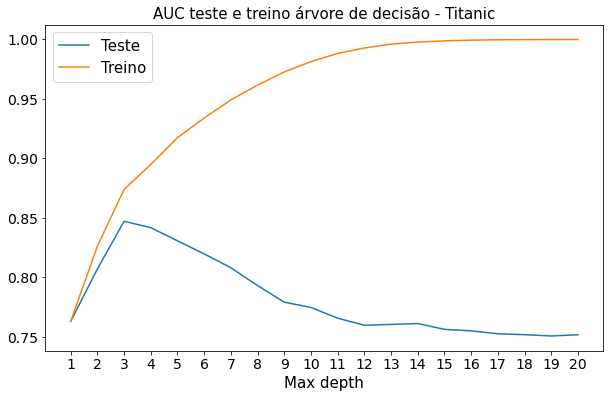

In [25]:
plt.figure(figsize = (10, 6))
ax = plt.gca()
plt.title("AUC teste e treino árvore de decisão - Titanic", fontsize = 15)
lista_arvore.plot(kind='line', x="x", y='teste',ax=ax)
lista_arvore.plot(kind='line', x="x", y='treino', ax=ax)
plt.legend(fontsize = 15, labels = ["Teste", "Treino"])
plt.xlabel("Max depth", fontsize = 15)
plt.xticks(list(range(1,21)))
plt.tick_params(axis = "both", which = "major", labelsize = 14)
plt.show()

O Resultado aqui foi bastante semelhante ao observado para o dataset do sírio-libanês, inclusive dando o mesmo valor "ótimo" de max depth de 3. Porém, a queda nos valores de AUC é relativamente mais brusca após o valor de 3, apenas estabilizando em valores mais baixos por volta do valor de 12. 

In [26]:
from sklearn.neighbors import KNeighborsClassifier

In [27]:
teste_lista = []
treino_lista = []

for i in range(1, 21):
  modelo_knn = KNeighborsClassifier(n_neighbors = i)
  teste, treino = roda_modelo_cv_titanic(modelo_knn, tc_ohe, 5, 10)
  teste_lista.append(teste)
  treino_lista.append(treino)

AUC 0.6496533880339794 - 0.9875013210502991
AUC 0.6970146474197664 - 0.9424824828547436
AUC 0.7244897576090327 - 0.9122482492335842
AUC 0.7246744345651146 - 0.8900143096146196
AUC 0.7229221862973865 - 0.8690247057683708
AUC 0.7268186058452418 - 0.8499941652289071
AUC 0.7296929468702181 - 0.8387994704073989
AUC 0.7317098273066033 - 0.8320470418519408
AUC 0.7322132066982873 - 0.8246440301861413
AUC 0.7359160782280244 - 0.8181465097069878
AUC 0.7358751328117453 - 0.8115905209913551
AUC 0.73459135541694 - 0.8062824489768857
AUC 0.7340528972024382 - 0.8009968909235201
AUC 0.7342976838648344 - 0.7958450286848098
AUC 0.7335621749607283 - 0.7916436158363913
AUC 0.7338928190150834 - 0.7876287688806678
AUC 0.7325173481370771 - 0.7848119307491908
AUC 0.732631857280117 - 0.7823202602246023
AUC 0.7333560117331868 - 0.7809561020429954
AUC 0.7344538348914884 - 0.7790710534687832


In [28]:
lista_knn = pd.DataFrame({
    "teste": teste_lista,
    "treino": treino_lista,
    "x": list(range(1, 21))})

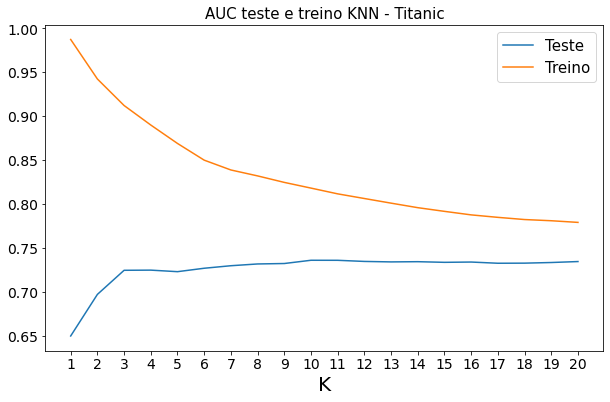

In [29]:
plt.figure(figsize = (10, 6))
ax = plt.gca()
plt.title("AUC teste e treino KNN - Titanic", fontsize = 15)
lista_knn.plot(kind='line', x="x", y='teste',ax=ax)
lista_knn.plot(kind='line', x="x", y='treino', ax=ax)
plt.legend(fontsize = 15, labels = ["Teste", "Treino"])
plt.xlabel("K", fontsize = 20)
plt.xticks(list(range(1,21)))
plt.tick_params(axis = "both", which = "major", labelsize = 14)
plt.show()

Aqui podemos ver que o KNN tem um comportamento diferente, em que a AUC do treino diminui conforme se aumenta muito o valor de K, a medida que a AUC do teste mantém-se relativamente estável. Nesse caso também podemos escolher o valor de 3 para K (o valor iterável relativamente comparável com o max_depth do decision tree), pois há o melhor compromisso entre AUC treino/teste.

# Desafio 03 - Estudar um pouco mais sobre overfit e underfit

Primeiro, o que é o "fit"? A terminologia aplicada é derivada diretamente da estátística, em que se busca aproximar os nossos dados à função matemática que melhor os descreve. Aportuguesamos um pouco esses termos em dizer "fitar" ou "fazer o fitting de modelos", que nada mais é buscar qual a melhor função matemática que descreve como os dados, geralmente tentanto estimar os valores y em função de x. Quando buscamos "a melhor função" em machine learning, a função "real" não é conhecida, e tecnicamente utilizamos "o melhor chute disponível", o que pode levar aos fenômenos de underfitting e overfitting. 
O Overfitting é quando o modelo "funciona bem até demais": a função estimada capta todo o ruído nos dados e entende isso como propriedade do sistema, o que nem sempre é verdade, já que muitas vezes lidamos com amostras de uma população estatística. Dessa forma, o modelo acaba prevendo com exatidão todos os pontos dos dados de treino, mas é incapaz de generalizar quando apresentado à novas situações diferentes do conjunto de dados de treino. 
O Underfitting, portanto, é o contrário? Na verdade não. Se um modelo não é capaz de detectar os padrões e prever bem o conjunto de dados de treino, ele também não será capaz de generalizar para novos dados, portanto, é uma performance igualmente ruim que um modelo apresente underfitting.

# Desafio 04 - Escolha um modelo de ML, estude os hiperparametros desse modelo e teste vários hiperparametros

Vamos brincar com o KNN que eu estudei anteriormente, agora voltando para o nosso dataset de covid do sirio libanes. Primeiro, gostaria de repetir o experimento que foi feito anteriormente, iterando o valor de K, que é peça fundamental no algoritmo KNN.

In [30]:
teste_lista = []
treino_lista = []

for i in range(1, 21):
  modelo_knn = KNeighborsClassifier(n_neighbors = i)
  teste, treino = roda_modelo_cv(modelo_knn, dados_limpos, 5, 10)
  teste_lista.append(teste)
  treino_lista.append(treino)

AUC 0.5955223420190526 - 1.0
AUC 0.602352916612785 - 0.9193295245642211
AUC 0.6029957042868228 - 0.8714441319953491
AUC 0.5954506120953489 - 0.8450099732250328
AUC 0.5811683289150394 - 0.818003509916378
AUC 0.5714571816134316 - 0.7927338349870352
AUC 0.55726237526402 - 0.7716735134336368
AUC 0.5423663937561964 - 0.7451352714296445
AUC 0.5286077120781069 - 0.7249447789325504
AUC 0.5199221006293374 - 0.7090357909749407
AUC 0.5071023804905384 - 0.6909990474644728
AUC 0.49312421198111983 - 0.670022036236056
AUC 0.475771888066296 - 0.6501672875681015
AUC 0.4710731672162593 - 0.6345144165914333
AUC 0.47414479072373816 - 0.6225119870271784
AUC 0.4705258914716151 - 0.6129673485393807
AUC 0.4697767751303936 - 0.603793489903717
AUC 0.4670222180912971 - 0.5953499163512527
AUC 0.46721082401181085 - 0.5895402071457766
AUC 0.4691390792706583 - 0.5864774161174169


In [31]:
lista_knn = pd.DataFrame({
    "teste": teste_lista,
    "treino": treino_lista,
    "x": list(range(1, 21))})

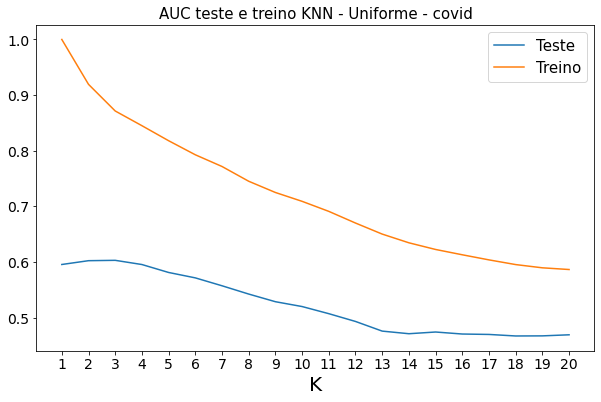

In [32]:
plt.figure(figsize = (10, 6))
ax = plt.gca()
plt.title("AUC teste e treino KNN - Uniforme - covid", fontsize = 15)
lista_knn.plot(kind='line', x="x", y='teste',ax=ax)
lista_knn.plot(kind='line', x="x", y='treino', ax=ax)
plt.legend(fontsize = 15, labels = ["Teste", "Treino"])
plt.xlabel("K", fontsize = 20)
plt.xticks(list(range(1,21)))
plt.tick_params(axis = "both", which = "major", labelsize = 14)
plt.show()

É interessante notar que há uma queda de performance constante em ambos dados de treino e de teste. Por que isso ocorre? Uma particularidade do KNN é que com k = 1, a AUC tem score de 1, sendo na verdade um caso severo de overfitting. Da forma como o algoritmo funciona, o vizinho mais próximo de qualquer ponto é ele mesmo, então o algoritmo é incapaz de generalizar.

Outros parametros que podemos testar sobre o modelo KNN, são weight e metric. Todos eles são relativos a forma como a distância entre os pontos (nosso dados) em um plano n dimensional é calculada e interpretada.
- Weight diz a forma como as distâncias são interpretadas, se todas as distâncias tem o mesmo peso ou se distâncias maiores tem menor influência no algoritmo. Padrão = uniforme
- Metric indica qual a métrica utilizada para se calcular a distância no plano n dimensional, seja distância euclideana, distância de manhattan, minkowski, etc. Padrão = minkowski

Vamos testar então com o mesmo framework utilizado anteriormente, iterando os valores de K:

In [33]:
teste_lista = []
treino_lista = []

for i in range(1, 21):
  modelo_knn = KNeighborsClassifier(n_neighbors = i, weights="distance")
  teste, treino = roda_modelo_cv(modelo_knn, dados_limpos, 5, 10)
  teste_lista.append(teste)
  treino_lista.append(treino)

AUC 0.5955223420190526 - 1.0
AUC 0.6198093263718263 - 1.0
AUC 0.6222200512414329 - 1.0
AUC 0.6223821406633906 - 1.0
AUC 0.611228299172378 - 1.0
AUC 0.5991563887452045 - 1.0
AUC 0.5886327670373723 - 1.0
AUC 0.5782797345790767 - 1.0
AUC 0.5712340914479072 - 1.0
AUC 0.5657252063666537 - 1.0
AUC 0.5592556791241001 - 1.0
AUC 0.5516676769472822 - 1.0
AUC 0.5421285400232769 - 1.0
AUC 0.5396963231173757 - 1.0
AUC 0.5401141482391483 - 1.0
AUC 0.5388103070175437 - 1.0
AUC 0.5378895103237209 - 1.0
AUC 0.5359608172766067 - 1.0
AUC 0.5366762710677184 - 1.0
AUC 0.5375354002327686 - 1.0


In [34]:
lista_knn = pd.DataFrame({
    "teste": teste_lista,
    "treino": treino_lista,
    "x": list(range(1, 21))})

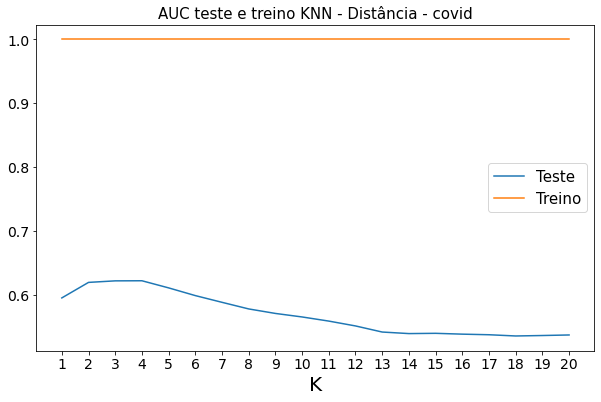

In [35]:
plt.figure(figsize = (10, 6))
ax = plt.gca()
plt.title("AUC teste e treino KNN - Distância - covid", fontsize = 15)
lista_knn.plot(kind='line', x="x", y='teste',ax=ax)
lista_knn.plot(kind='line', x="x", y='treino', ax=ax)
plt.legend(fontsize = 15, labels = ["Teste", "Treino"])
plt.xlabel("K", fontsize = 20)
plt.xticks(list(range(1,21)))
plt.tick_params(axis = "both", which = "major", labelsize = 14)
plt.show()

Overfitting exagerado. Se é que existe tal redundância!

In [36]:
teste_lista = []
treino_lista = []

for i in range(1, 21):
  modelo_knn = KNeighborsClassifier(n_neighbors = i, metric = "euclidean")
  teste, treino = roda_modelo_cv(modelo_knn, dados_limpos, 5, 10)
  teste_lista.append(teste)
  treino_lista.append(treino)

AUC 0.5955223420190526 - 1.0
AUC 0.602352916612785 - 0.9193295245642211
AUC 0.6029957042868228 - 0.8714441319953491
AUC 0.5954506120953489 - 0.8450099732250328
AUC 0.5811683289150394 - 0.818003509916378
AUC 0.5714571816134316 - 0.7927338349870352
AUC 0.55726237526402 - 0.7716735134336368
AUC 0.5423663937561964 - 0.7451352714296445
AUC 0.5286077120781069 - 0.7249447789325504
AUC 0.5199221006293374 - 0.7090357909749407
AUC 0.5071023804905384 - 0.6909990474644728
AUC 0.49312421198111983 - 0.670022036236056
AUC 0.475771888066296 - 0.6501672875681015
AUC 0.4710731672162593 - 0.6345144165914333
AUC 0.47414479072373816 - 0.6225119870271784
AUC 0.4705258914716151 - 0.6129673485393807
AUC 0.4697767751303936 - 0.603793489903717
AUC 0.4670222180912971 - 0.5953499163512527
AUC 0.46721082401181085 - 0.5895402071457766
AUC 0.4691390792706583 - 0.5864774161174169


In [37]:
lista_knn = pd.DataFrame({
    "teste": teste_lista,
    "treino": treino_lista,
    "x": list(range(1, 21))})

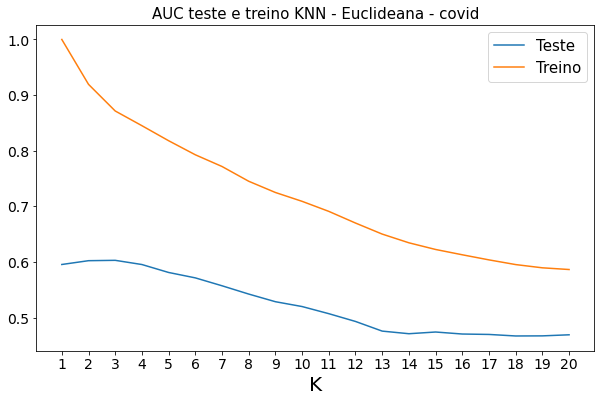

In [38]:
plt.figure(figsize = (10, 6))
ax = plt.gca()
plt.title("AUC teste e treino KNN - Euclideana - covid", fontsize = 15)
lista_knn.plot(kind='line', x="x", y='teste',ax=ax)
lista_knn.plot(kind='line', x="x", y='treino', ax=ax)
plt.legend(fontsize = 15, labels = ["Teste", "Treino"])
plt.xlabel("K", fontsize = 20)
plt.xticks(list(range(1,21)))
plt.tick_params(axis = "both", which = "major", labelsize = 14)
plt.show()

In [39]:
teste_lista = []
treino_lista = []

for i in range(1, 21):
  modelo_knn = KNeighborsClassifier(n_neighbors = i, metric = "manhattan")
  teste, treino = roda_modelo_cv(modelo_knn, dados_limpos, 5, 10)
  teste_lista.append(teste)
  treino_lista.append(treino)

AUC 0.5777277037803354 - 1.0
AUC 0.5930942807340833 - 0.9242418240871142
AUC 0.615588865629984 - 0.8801772329835587
AUC 0.6315220618345618 - 0.8612897915883376
AUC 0.637059975645502 - 0.8483256146709302
AUC 0.6384384496637786 - 0.8346527813822491
AUC 0.6418677461851804 - 0.8189271806647159
AUC 0.6387139599228415 - 0.8047359911629509
AUC 0.6254783880770723 - 0.7939347914061812
AUC 0.6116130813828182 - 0.7781512691502315
AUC 0.6046308973447131 - 0.7623183467010322
AUC 0.6080785742381137 - 0.7496406457388567
AUC 0.6116089392322944 - 0.7426861948815235
AUC 0.6097188523751024 - 0.7409092595806674
AUC 0.6109742607439975 - 0.7387515797476294
AUC 0.605591593387646 - 0.7302038833322042
AUC 0.6034733447562395 - 0.7219725273372988
AUC 0.597060689577137 - 0.7144908695560517
AUC 0.5956264817449027 - 0.70936971280358
AUC 0.5964220171128065 - 0.7042616011469314


In [40]:
lista_knn = pd.DataFrame({
    "teste": teste_lista,
    "treino": treino_lista,
    "x": list(range(1, 21))})

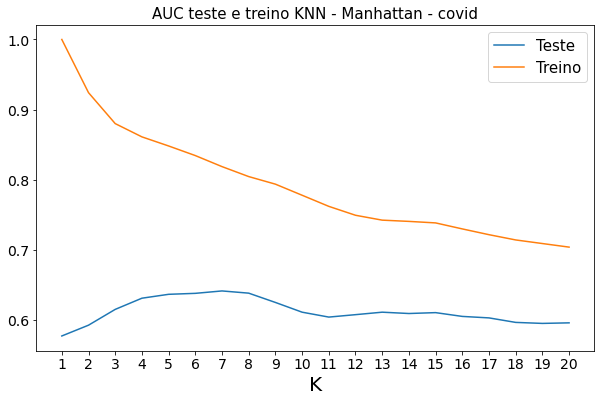

In [41]:
plt.figure(figsize = (10, 6))
ax = plt.gca()
plt.title("AUC teste e treino KNN - Manhattan - covid", fontsize = 15)
lista_knn.plot(kind='line', x="x", y='teste',ax=ax)
lista_knn.plot(kind='line', x="x", y='treino', ax=ax)
plt.legend(fontsize = 15, labels = ["Teste", "Treino"])
plt.xlabel("K", fontsize = 20)
plt.xticks(list(range(1,21)))
plt.tick_params(axis = "both", which = "major", labelsize = 14)
plt.show()

In [42]:
teste_lista = []
treino_lista = []

for i in range(1, 21):
  modelo_knn = KNeighborsClassifier(n_neighbors = i, metric = "chebyshev")
  teste, treino = roda_modelo_cv(modelo_knn, dados_limpos, 5, 10)
  teste_lista.append(teste)
  treino_lista.append(treino)

AUC 0.5646357062804431 - 1.0
AUC 0.5652167186624424 - 0.9037418436842944
AUC 0.5727396520324153 - 0.8480208876775592
AUC 0.5762801871847925 - 0.8188386941001948
AUC 0.5648094880167249 - 0.7994855034592347
AUC 0.5524426025906289 - 0.7796938497294359
AUC 0.5446801788331392 - 0.7573797748555182
AUC 0.5277863539376697 - 0.7380831383507709
AUC 0.5052981540152593 - 0.7138827046339605
AUC 0.48285213667614973 - 0.6851585708139758
AUC 0.4663580932906591 - 0.6604540675098808
AUC 0.459388066295961 - 0.638774015193085
AUC 0.4523999283374283 - 0.6208006956026793
AUC 0.447563378270615 - 0.6102461977376974
AUC 0.45508332794517 - 0.6028217844455492
AUC 0.4567838996292944 - 0.5968403080789298
AUC 0.4564979767446873 - 0.5885984493002016
AUC 0.4570121961075908 - 0.5833549749309596
AUC 0.45858306796629167 - 0.5797340621710565
AUC 0.46074941942540626 - 0.5789216568438572


In [43]:
lista_knn = pd.DataFrame({
    "teste": teste_lista,
    "treino": treino_lista,
    "x": list(range(1, 21))})

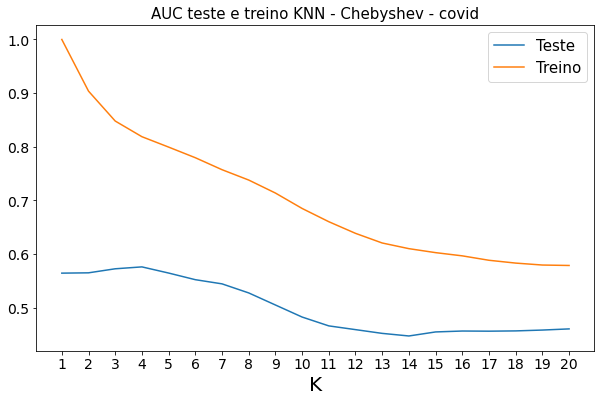

In [44]:
plt.figure(figsize = (10, 6))
ax = plt.gca()
plt.title("AUC teste e treino KNN - Chebyshev - covid", fontsize = 15)
lista_knn.plot(kind='line', x="x", y='teste',ax=ax)
lista_knn.plot(kind='line', x="x", y='treino', ax=ax)
plt.legend(fontsize = 15, labels = ["Teste", "Treino"])
plt.xlabel("K", fontsize = 20)
plt.xticks(list(range(1,21)))
plt.tick_params(axis = "both", which = "major", labelsize = 14)
plt.show()

A distância de manhattan nesse caso parece ser a que possui melhor peformance! A forma como a distância é calculada parece ter bastante influência na acurácia do algoritmo, pode ser um caminho interessante explorar mais todas as métricas disponíveis e avaliar qual a melhor alternativa.

# Desafio 05 - Pesquisar como salvar um modelo treinado

Em alguns exemplos online, encontrei a biblioteca pickle, que parece ser bastante utilizada para o armazenamento de objetos de modelos de ML.

In [45]:
import pickle

In [46]:
dados_pickle = dados_limpos.sample(frac = 1).reset_index(drop = True)
x_columns = dados_pickle.columns
y = dados_pickle["ICU"]
x = dados_pickle[x_columns].drop(["ICU", "WINDOW"], axis = 1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

model_pickle = DecisionTreeClassifier(max_depth = 3)

In [47]:
model_pickle.fit(x_train, y_train)
filename = "modelo_dt_teste_pickle.sav"

In [48]:
pickle.dump(model_pickle, open(filename, "wb"))

Agora o arquivo está salvo no workspace: 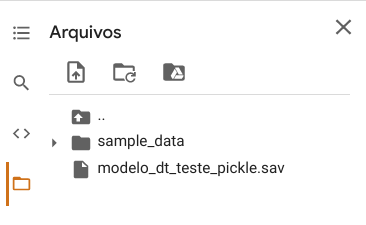

In [49]:
loaded_model = pickle.load(open(filename, "rb"))

In [50]:
result = loaded_model.score(x_test, y_test)
print(result)

0.6338028169014085


Outra biblioteca que parece atuar de forma muito parecida (e com uma sintaxe inclusive mais simples) é o joblib:

In [51]:
import joblib

In [52]:
filename = "modelo_dt_teste_joblib.sav"
joblib.dump(model_pickle, filename)

['modelo_dt_teste_joblib.sav']

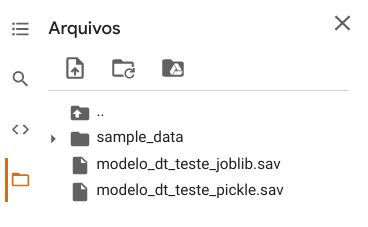

In [53]:
loaded_model_2 = joblib.load(filename)

In [54]:
result = loaded_model_2.score(x_test, y_test)
print(result)

0.6338028169014085
